# Notebook 2B. Time Series Forecasting using RNN
---
Organized and prepared by Christopher Monterola, updated by Kenneth Co.

This notebook was conceptualized, organized, and primarily prepared for the **Machine Learning** courses.

### This notebook uses the following references:
1. Python Machine Learning, Second Edition, Sebastian Raschka and Vahid Mirjalili, Packt Publishing Ltd. Birmingham B3 2PB, UK Sept 2017.
2. Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurélien Géron, O'Reilly 2017.
3. Deep Learning with Python, Francois Chollet, Manning New York 2018.

---
In this notebook, we will continue in illustrating RNN by using it to  work on the following: **Temperature forecasting problem**.

## Google Colab Setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/data/'
# IMG_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/images/'
# MODEL_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/'

DATA_DIR = 'data/'
IMG_DIR = 'images/'
MODEL_DIR = 'models/'

First, enable GPUs for the notebook:

- Navigate to ```Edit → Notebook Settings``` in the toolbar
- Select ```GPU``` or ```TPU```from the Hardware Accelerator drop-down

Next, verify if GPU or TPU is enabled. You will know this by running the code script below. It should show that a GPU is recognized.

In [ ]:
import torch
import tensorflow as tf

# Check PyTorch CUDA Version
print("PyTorch CUDA Version:")
try:
    print(torch.version.cuda)
except AttributeError:
    print("CUDA not available with this PyTorch installation.")

# Check TensorFlow CUDA Version
print("\nTensorFlow CUDA Version:")
try:
    print(tf.sysconfig.get_build_info()['cuda_version'])
except KeyError:
    print("CUDA not used in this TensorFlow build.")

# Additional checks for GPU availability
print("\nGPU Availability:")
print("PyTorch CUDA Availability:", torch.cuda.is_available())
print("TensorFlow GPU Devices:", len(tf.config.list_physical_devices('GPU')) > 0)

PyTorch CUDA Version:
None

TensorFlow CUDA Version:
CUDA not used in this TensorFlow build.

GPU Availability:
PyTorch CUDA Availability: False
TensorFlow GPU Devices: True


In the next example, we’ll review three advanced techniques for improving the performance and generalization power of recurrent neural networks.  We’ll demonstrate all three concepts on a temperature-forecasting problem, where you have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, which you use to predict what the temperature will be 24 hours after the last data point.

This is a fairly challenging problem that exemplifies many common difficulties encountered when working with timeseries. We’ll cover the following techniques:
- GRU based architecture in contrast with simple RNN and LSTM    
- Recurrent dropout—This is a specific, built-in way to use dropout to fight overfitting in recurrent layers.    
- Stacking recurrent layers—This increases the representational power of the network (at the cost of higher computational loads).    

# Example 2: Temperature Forecasting
---

Sequence data is found in diverse problems other than just language processing. In all the examples in this section, you’ll play with a weather timeseries dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany.

In this dataset, 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. The original data goes back to 2003, but this example is limited to data from 2009–2016. This dataset is perfect for learning to work with numerical timeseries. You’ll use it to build a model that takes as input some data from the recent past (a few days’ worth of data points) and predicts the air temperature 24 hours in the future.

Here are the actual variables in the data:
* Date Time   
* p (mbar) atmospheric pressure  
* T (degC) temperature  
* Tpot (K) potential temperature  
* Tdew (degC) dew point temperature  
* rh (%) relative humidity  
* VPmax (mbar) saturation water vapor pressure  
* VPact (mbar) actual water vapor pressure  
* VPdef (mbar) water vapor pressure deficit  
* sh (g/kg) specific humidity  
* H2OC (mmol/mol) water vapor concentration  
* rho (g/$m^3$) air density  
* wv (m/s) wind velocity  
* max. wv (m/s) maximum wind velocity  
* wd (deg) wind direction  


## Step 1. Get the data

Download and uncompress the data as follows:

### Inspecting the data of the Jena weather dataset

In [3]:
import os

fname = DATA_DIR + 'jena_climate_2009_2016.csv'
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [4]:
import pandas as pd

data2 = pd.read_csv(DATA_DIR + 'jena_climate_2009_2016.csv')
dummy=data2
dummy.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Now, convert all 420,551 lines of data into a Numpy array.

In [5]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [6]:
float_data.shape

(420551, 14)

## Step 2. Visualize by plotting the temperature timeseries

You can clearly see the yearly periodicity of temperature.

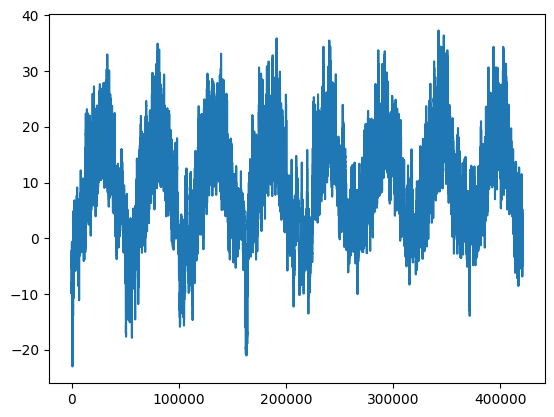

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  #temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

Below is a more narrow plot of the first 10 days of temperature data or first 1440 data points. Because the data is recorded every 10 minutes, you get 144 data points daily.

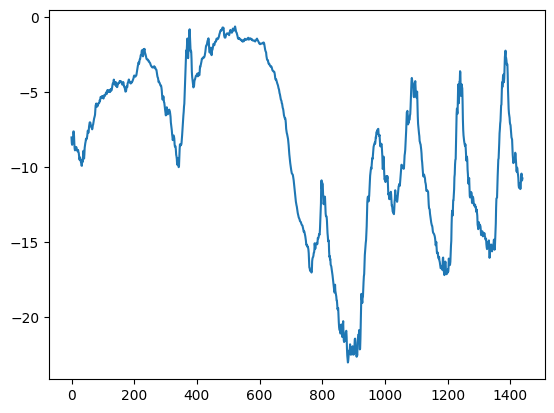

In [8]:
plt.plot(range(1440), temp[:1440])

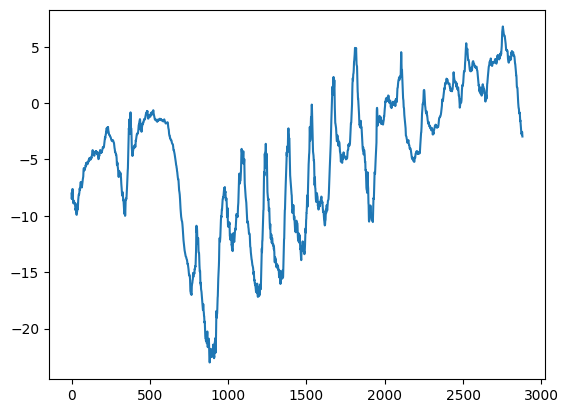

In [9]:
plt.plot(range(2880), temp[:2880])

On this plot, you can see daily periodicity, especially evident for the last 4 days. Also note that this 10-day period must be coming from a fairly cold winter month. If you were trying to predict average temperature for the next month given a few months of past data, the problem would be easy, due to the reliable year-scale periodicity
of the data.

But looking at the data over a scale of days, the temperature looks a lot more chaotic. Is this timeseries predictable at a daily scale? Let’s find out. Shown below are plots for 100 days ($2880*5$) and 200 days ($2880*10$)

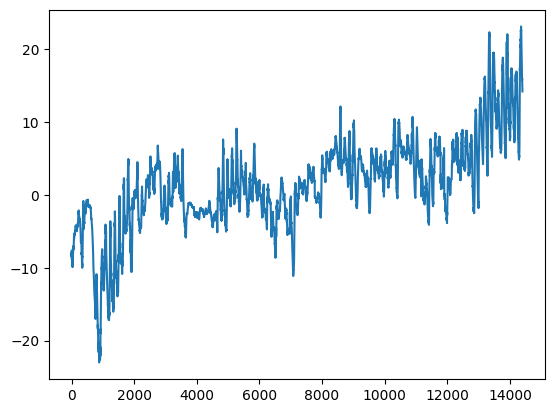

In [10]:
plt.plot(range(2880*5), temp[:2880*5])

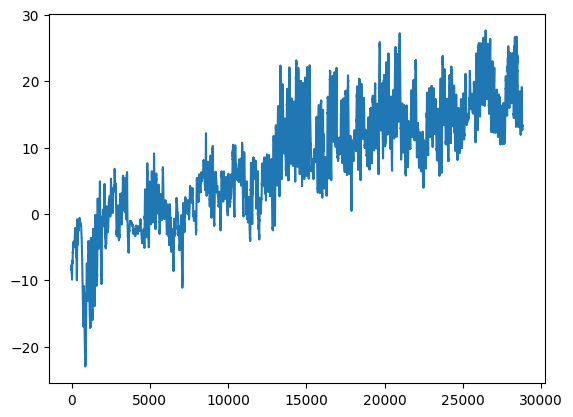

In [11]:
plt.plot(range(2880*10), temp[:2880*10])

## Step 3. Preparing the data

The exact formulation of the problem will be as follows: given data going as far back as lookback timesteps (a timestep is 10 minutes) and sampled every steps timesteps, can you predict the temperature in delay timesteps?

You’ll use the following parameter values:

*  lookback = 1440—Observations will go back 10 days (10 days $\times$ 144
timesteps/day).   
*  steps = 6—Observations will be sampled at one data point per hour.   
*  delay = 144—Targets will be 24 hours in the future.   


<img width="1000" alt="FeedforwardNN_timeseries" src="https://user-images.githubusercontent.com/25600601/144736049-ebbb847e-a47f-4eab-8556-2ac9275b46f0.png">

<img width="1000" alt="RNNGRULSTM_timeseries" src="https://user-images.githubusercontent.com/25600601/144736075-aa23f072-f388-4d20-b268-63e741e6427c.png">


To get started, you need to do two things: **A. Normalization** and ** B. Sampling**

**A. Normalization**: Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each time series in the data is on a different scale (for example, temperature is typically between -20 and +30 celsius, but atmospheric pressure, measured in mbar, is around 1,000). You’ll normalize each timeseries independently so that they all take small values on a similar scale.    

**B. Sampling**: Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, you’ll generate the samples on the fly using the original data.   

You’ll preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation.

*You’re going to use the first 200,000 timesteps as training data, so compute the mean and standard deviation only on this fraction of the data.*


### Step 3A. Normalize the data

In [12]:

# Normalize data
mean = float_data[:200000].mean(axis=0)
std = float_data[:200000].std(axis=0)
normalized_data = (float_data - mean) / std

Listed in the code below are the data generator function you’ll use. It yields a tuple (samples, targets), where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:
    
* **data**—The original array of floating-point data, which you normalized above.  
* **lookback**—How many timesteps back the input data should go.  
* **delay**—How many timesteps in the future the target should be.  
* **min_index** and **max_index**—Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.  
* **shuffle**—Whether to shuffle the samples or draw them in chronological order.  
* **batch_size**—The number of samples per batch.  
* **step**—The period, in timesteps, at which you sample data. You’ll set it to 6 in order to draw one data point every hour. note that the number of inputs = lookback/step  

### Step 3B. Sampling the data
Generator yielding time series samples and their targets

In [13]:
import torch
import numpy as np
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback, delay, min_index, max_index, step):
        self.data = data
        self.lookback = lookback
        self.delay = delay
        self.min_index = min_index
        self.max_index = max_index if max_index is not None else len(data) - delay - 1
        self.step = step

    def __len__(self):
        return self.max_index - self.min_index - self.lookback + 1

    def __getitem__(self, index):
        i = self.min_index + index + self.lookback
        indices = range(i - self.lookback, i, self.step)
        samples = self.data[indices]
        target = self.data[i + self.delay][1]  # second column (index 1) is the target variable

        return torch.tensor(samples, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

### Step 3C. Preparing the training, validation, and test generation

In [14]:
from torch.utils.data import DataLoader

NUM_WORKERS = 6

lookback = 1440
step = 6
delay = 144 * 2
batch_size = 128

train_dataset = TimeSeriesDataset(normalized_data, lookback, delay, 0, 200000, step)
val_dataset = TimeSeriesDataset(normalized_data, lookback, delay, 200001, 300000, step)
test_dataset = TimeSeriesDataset(normalized_data, lookback, delay, 300001, None, step)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

<div class="alert alert-block alert-info">

## ⚠️ Sign Post ⚠️
Run the code until here, then you can proceed to any of the next steps without issues since you have already pre-processed the data.
</div>

## Step 4. Understand the baseline
Before you start using black-box deep-learning models to solve the temperatureprediction problem, let’s try a simple, common-sense approach. It will serve as a sanity check, and it will establish a baseline that you’ll have to beat in order to demonstrate the usefulness of more-advanced

### Baseline Error

Common-sense baselines can be useful when you’re approaching a new problem for which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes are much more common than others. If your dataset contains 90% instances of class A and 10% instances of class B, then a common-sense approach to
the classification task is to always predict “A” when presented with a new sample. Such a classifier is 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness.

Sometimes, such elementary baselines can prove surprisingly hard to beat.   

In this case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common-sense approach is to predict **that the temperature 24 hours from now will be equal to the temperature right now.**

*Today is essentially the same as yesterday.*

Let’s evaluate this approach, using the mean absolute error (MAE = $\sum_{i=1}^{N} \frac{|Theoretical_i - Actual_i|}{N} = \sum_{i=1}^{N} \frac{|error_i|}{N}$) metric: *np.mean(np.abs(preds - targets))*

In [15]:
def evaluate_naive_method(loader):
    maes = []
    for samples, targets in loader:
        preds = samples[:, -1, 1]  # last time step's temperature as prediction
        mae = torch.mean(torch.abs(preds - targets))
        maes.append(mae.item())
    return np.mean(maes)

# Evaluate
naive_mae = evaluate_naive_method(val_loader)
print(f"Naive method MAE on validation set: {naive_mae}")

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/miniconda3/envs/mltfpy39/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/miniconda3/envs/mltfpy39/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'TimeSeriesDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [ ]:
print(f'Celcius MAE on val: {naive_mae * std[1]}')

Celcius MAE on val: 3.282520095215499


Because the temperature data has been normalized to be centered on 0 and have a standard deviation of 1, this number isn’t immediately interpretable. It translates to an average absolute error of MAE × temperature_std degrees Celsius: 3.3-3.6°C.

That’s a fairly large average absolute error. Now the game is to use your knowledge of
deep learning to do better.

## Step 5. Model 1: Feedforward Neural Networks
In the same way that it’s useful to establish a common-sense baseline before trying machine-learning approaches, it’s useful to try simple, cheap machine-learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any
further complexity you throw at the problem is legitimate and delivers real benefits. The following listing shows a fully connected model that starts by flattening the data and then runs it through two Dense layers. Note the lack of activation function on the last Dense layer, which is typical for a regression problem. You use MAE as the loss.

Because you evaluate on the exact same data and with the exact same metric you did with the common-sense approach, the results will be directly comparable.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_shape[0] * input_shape[1], 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Determine input shape based on your data structure
input_shape = (lookback // step, float_data.shape[-1])
model = Net(input_shape)

# Print model architecture
print(model)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3360, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [17]:
from torchinfo import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(model, input_size=(1, input_shape[0], input_shape[1]), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 1]                    --
├─Flatten: 1-1                           [1, 3360]                 --
├─Linear: 1-2                            [1, 32]                   107,552
├─ReLU: 1-3                              [1, 32]                   --
├─Linear: 1-4                            [1, 1]                    33
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.43
Estimated Total Size (MB): 0.44

In [ ]:
# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Loss and optimizer
criterion = nn.L1Loss()  # MAE in PyTorch
optimizer = optim.RMSprop(model.parameters())

# We'll use these lists to store loss history
train_losses = []
val_losses = []

# Training loop
def train_model(model, train_loader, val_loader, epochs):

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))  # Ensure target matches output shape
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Store the average loss for plotting

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.to(device))
                val_loss += loss.item()

        # Average validation loss for this epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Store the average validation loss for plotting

        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Train the model
train_model(model, train_loader, val_loader, epochs=20)

cpu


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/miniconda3/envs/mltfpy39/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/miniconda3/envs/mltfpy39/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'TimeSeriesDataset' on <module '__main__' (built-in)>


Let’s display the loss curves for validation and training.

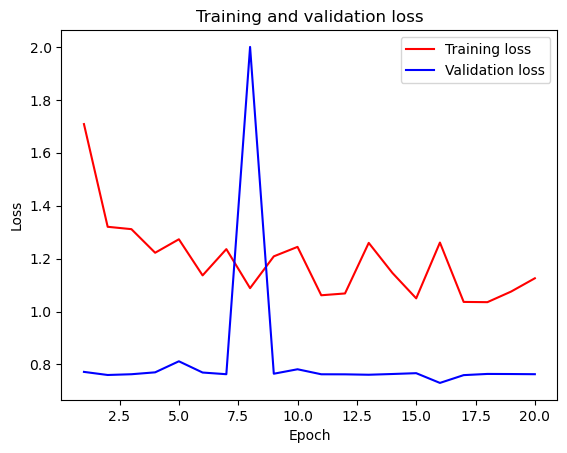

In [ ]:
import matplotlib.pyplot as plt

max_loss_threshold = 2

# Clip the losses to this threshold
clipped_train_losses = np.clip(train_losses, None, max_loss_threshold)
clipped_val_losses = np.clip(val_losses, None, max_loss_threshold)

# Plotting the loss curves
epochs = range(1, len(train_losses) + 1)

plt.figure()

plt.plot(epochs, clipped_train_losses, 'r', label='Training loss')
plt.plot(epochs, clipped_val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Step 6. Model 2: LSTM
We now test the LSTM model we learned in Notebook 2A.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        # LSTM Layer:
        # - 32 units, as in the Keras model
        # - input_size is the number of features
        self.lstm = nn.LSTM(input_size, 32, batch_first=True)
        # Dense Layer:
        # - 32 (from LSTM) to 1 output (since we're predicting one value)
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, features)
        lstm_out, _ = self.lstm(x)
        # We only care about the last output of LSTM for prediction
        # Assuming variable length sequences, we take the last output from each batch
        if x.dim() == 3:  # (batch, seq, feature)
            lstm_out = lstm_out[:, -1, :]  # Take last time step
        else:  # If not batched
            lstm_out = lstm_out[-1, :]  # Take last time step

        # Pass through dense layer
        output = self.dense(lstm_out)
        return output

# Define the model with the right input size
input_size = 14  # Number of features in your data
model = LSTMModel(input_size)

# Print model summary
print(model)

# If you want to see the number of parameters:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

LSTMModel(
  (lstm): LSTM(14, 32, batch_first=True)
  (dense): Linear(in_features=32, out_features=1, bias=True)
)
Total parameters: 6177


In [ ]:
# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Loss and optimizer
criterion = nn.L1Loss()  # MAE in PyTorch
optimizer = optim.RMSprop(model.parameters())

# We'll use these lists to store loss history
train_losses = []
val_losses = []

# Training loop
def train_model(model, train_loader, val_loader, epochs):

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.unsqueeze(1).to(device))  # Ensure target matches output shape
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Store the average loss for plotting

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.unsqueeze(1).to(device))
                val_loss += loss.item()

        # Average validation loss for this epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Store the average validation loss for plotting

        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Train the model
train_model(model, train_loader, val_loader, epochs=20)

cuda
Epoch 1/20, Train Loss: 0.3442, Val Loss: 0.3724
Epoch 2/20, Train Loss: 0.2858, Val Loss: 0.3848
Epoch 3/20, Train Loss: 0.2568, Val Loss: 0.3789
Epoch 4/20, Train Loss: 0.2513, Val Loss: 0.3964
Epoch 5/20, Train Loss: 0.2365, Val Loss: 0.4015
Epoch 6/20, Train Loss: 0.2330, Val Loss: 0.3952
Epoch 7/20, Train Loss: 0.2313, Val Loss: 0.4154
Epoch 8/20, Train Loss: 0.2284, Val Loss: 0.4124
Epoch 9/20, Train Loss: 0.2867, Val Loss: 0.3814
Epoch 10/20, Train Loss: 0.3191, Val Loss: 0.3690
Epoch 11/20, Train Loss: 0.2977, Val Loss: 0.3924
Epoch 12/20, Train Loss: 0.3143, Val Loss: 0.3768
Epoch 13/20, Train Loss: 0.3958, Val Loss: 0.3826
Epoch 14/20, Train Loss: 0.4137, Val Loss: 0.3928
Epoch 15/20, Train Loss: 0.4234, Val Loss: 0.4002
Epoch 16/20, Train Loss: 0.4168, Val Loss: 0.3938
Epoch 17/20, Train Loss: 0.4266, Val Loss: 0.4039
Epoch 18/20, Train Loss: 0.4279, Val Loss: 0.4083
Epoch 19/20, Train Loss: 0.4285, Val Loss: 0.4073
Epoch 20/20, Train Loss: 0.4308, Val Loss: 0.4038


Let’s display the loss curves for validation and training.

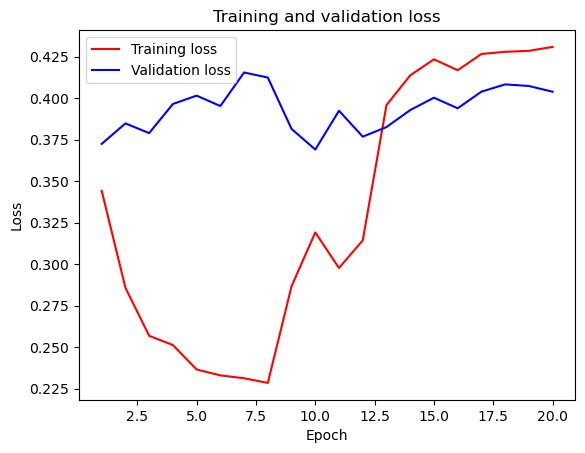

In [ ]:
import matplotlib.pyplot as plt

max_loss_threshold = 2

# Clip the losses to this threshold
clipped_train_losses = np.clip(train_losses, None, max_loss_threshold)
clipped_val_losses = np.clip(val_losses, None, max_loss_threshold)

# Plotting the loss curves
epochs = range(1, len(train_losses) + 1)

plt.figure()

plt.plot(epochs, clipped_train_losses, 'r', label='Training loss')
plt.plot(epochs, clipped_val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Step 7. Recurrent dropout to fight overfitting
It’s evident from the training and validation curves that the model is overfitting: the training and validation losses start to diverge considerably after a few epochs.

You’re already familiar with a classic technique for fighting this phenomenon: dropout, which randomly zeros out input units of a layer in order to break incidental correlations in the training data that the layer is exposed to. But how to correctly apply dropout in recurrent networks isn’t a trivial question. It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his PhD thesis on Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of a dropout mask that varies randomly from timestep to timestep.

What’s more, in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers (see Figure 1 below from https://becominghuman.ai/learning-note-dropout-in-recurrent-networks-part-1-57a9c19a2307). Every recurrent layer in Keras has two dropout-related arguments: dropout, a float specifying the dropout rate for input units of the layer, and recurrent_dropout, specifying the dropout rate of the recurrent units. Let’s add
dropout and recurrent dropout to the GRU layer and see how doing so impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, you’ll train the network for twice as many epochs.


<img width="722" alt="dropouts" src="https://user-images.githubusercontent.com/25600601/144736347-2aa40588-a080-4f38-a868-8faf3f858a00.png">


Let's try and mitigate the overfitting using dropout.

<div class="alert alert-block alert-info">

## ⚠️ Checkpoint ⚠️

In the next 10-15 minutes, try changing the following with your LT to see if you can improve on the MAE of 0.2699:
- Dropout
- Smaller/Bigger LSTM
</div>

## Step 8. Model 3: Gated Recurrent Unit (GRU)
Aside form the LSTM layer introduced in the previous lecture, we will implement also the GRU developed by Chung et al. in 2014.

The first fully connected approach didn’t do well, but that doesn’t mean machine learning isn’t applicable to this problem. The previous approach first flattened the timeseries, which removed the notion of time from the input data. Let’s instead look at the data as what it is: a sequence, where causality and order matter. You’ll try a recurrent-sequence processing model—it should be the perfect fit for such sequence data, precisely because it exploits the temporal ordering of data points, unlike the first approach. Gated recurrent unit (GRU) layers work using the same principle as LSTM, but they’re somewhat streamlined and thus cheaper to run (although they may not have as much representational power as
LSTM). This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.  Note the dot in our previous figure is the $\times$ here.

![RNN_LSTMvsGRU](https://user-images.githubusercontent.com/25600601/144736256-f2a3e628-7b65-428b-8349-7f98c7e9d452.jpeg)

In [ ]:
import torch
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, 32, batch_first=True)
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
        # GRU expects input of shape (batch_size, sequence_length, features)
        gru_out, _ = self.gru(x)
        # We only care about the last output of GRU for prediction
        # Assuming variable length sequences, we take the last output from each batch
        if x.dim() == 3:  # (batch, seq, feature)
            gru_out = gru_out[:, -1, :]  # Take last time step
        else:  # If not batched
            gru_out = gru_out[-1, :]  # Take last time step

        output = self.dense(gru_out)
        return output

# Define the model with the right input size
input_size = 14
model = GRUModel(input_size)

# Print model summary
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

GRUModel(
  (gru): GRU(14, 32, batch_first=True)
  (dense): Linear(in_features=32, out_features=1, bias=True)
)
Total parameters: 4641


In [ ]:
# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Loss and optimizer
criterion = nn.L1Loss()  # MAE in PyTorch
optimizer = optim.RMSprop(model.parameters())

# We'll use these lists to store loss history
train_losses = []
val_losses = []

# Training loop
def train_model(model, train_loader, val_loader, epochs):

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.unsqueeze(1).to(device))  # Ensure target matches output shape
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Store the average loss for plotting

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.unsqueeze(1).to(device))
                val_loss += loss.item()

        # Average validation loss for this epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Store the average validation loss for plotting

        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Train the model
train_model(model, train_loader, val_loader, epochs=20)

cuda
Epoch 1/20, Train Loss: 0.2982, Val Loss: 0.4088
Epoch 2/20, Train Loss: 0.2470, Val Loss: 0.4134
Epoch 3/20, Train Loss: 0.2372, Val Loss: 0.4363
Epoch 4/20, Train Loss: 0.2523, Val Loss: 0.4073
Epoch 5/20, Train Loss: 0.2507, Val Loss: 0.4083
Epoch 6/20, Train Loss: 0.2863, Val Loss: 0.4124
Epoch 7/20, Train Loss: 0.3422, Val Loss: 0.4158
Epoch 8/20, Train Loss: 0.3804, Val Loss: 0.4052
Epoch 9/20, Train Loss: 0.3944, Val Loss: 0.4529
Epoch 10/20, Train Loss: 0.3773, Val Loss: 0.3885
Epoch 11/20, Train Loss: 0.3912, Val Loss: 0.4159
Epoch 12/20, Train Loss: 0.3989, Val Loss: 0.4387
Epoch 13/20, Train Loss: 0.4039, Val Loss: 0.4021
Epoch 14/20, Train Loss: 0.3949, Val Loss: 0.4013
Epoch 15/20, Train Loss: 0.3745, Val Loss: 0.3889
Epoch 16/20, Train Loss: 0.3625, Val Loss: 0.3727
Epoch 17/20, Train Loss: 0.3816, Val Loss: 0.3905
Epoch 18/20, Train Loss: 0.3995, Val Loss: 0.4225
Epoch 19/20, Train Loss: 0.4035, Val Loss: 0.3851
Epoch 20/20, Train Loss: 0.4040, Val Loss: 0.3877


Let’s display the loss curves for validation and training.

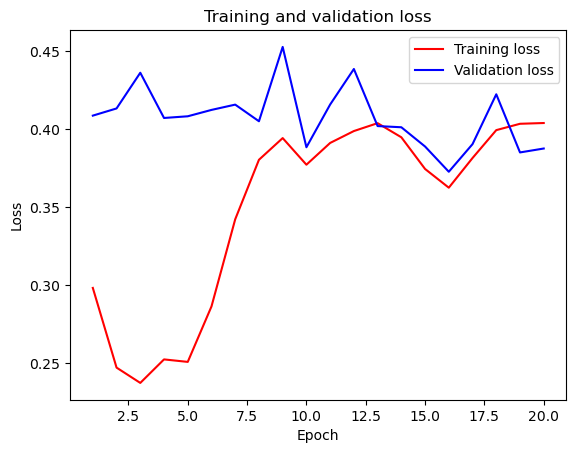

In [ ]:
import matplotlib.pyplot as plt

max_loss_threshold = 2

# Clip the losses to this threshold
clipped_train_losses = np.clip(train_losses, None, max_loss_threshold)
clipped_val_losses = np.clip(val_losses, None, max_loss_threshold)

# Plotting the loss curves
epochs = range(1, len(train_losses) + 1)

plt.figure()

plt.plot(epochs, clipped_train_losses, 'r', label='Training loss')
plt.plot(epochs, clipped_val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Step 9. Stacking recurrent layers

Because you’re no longer overfitting but seem to have hit a performance bottleneck, you should consider increasing the capacity of the network.

Recall the description of the universal machine-learning workflow: it’s generally a good idea to increase the capacity of your network until overfitting becomes the primary obstacle (assuming you’re already taking basic steps to mitigate overfitting, such as using dropout). As long as you aren’t overfitting too badly, you’re likely under capacity.    

Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer stacking is a classic way to build more-powerful recurrent networks: for instance, what currently powers the Google to translate algorithm is a stack of seven large LSTM layers—that’s huge.   

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. This is done by specifying return_sequences=True.

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size):
        super(GRUModel, self).__init__()
        # First GRU Layer:
        self.gru1 = nn.GRU(input_size, 16, dropout=0.1, bidirectional=False, batch_first=True)
        # Here, we manually set recurrent_dropout using a custom wrapper
        self.gru1_dropout = nn.Dropout(0.2)

        # Second GRU Layer:
        self.gru2 = nn.GRU(16, 32, dropout=0.1, bidirectional=False, batch_first=True)
        self.gru2_dropout = nn.Dropout(0.2)

        # Dense Layer:
        self.dense = nn.Linear(32, 1)

        # Activation for the second GRU layer
        self.relu = nn.ReLU()

    def forward(self, x):
        # First GRU layer with recurrent dropout
        gru1_out, _ = self.gru1(x)
        gru1_out = self.gru1_dropout(gru1_out)

        # Second GRU layer
        gru2_out, _ = self.gru2(gru1_out)
        gru2_out = self.gru2_dropout(gru2_out)
        gru2_out = self.relu(gru2_out)

        # We take the last output of the sequence for prediction
        if x.dim() == 3:  # (batch, seq, feature)
            gru2_out = gru2_out[:, -1, :]  # Take last time step
        else:  # If not batched
            gru2_out = gru2_out[-1, :]  # Take last time step

        # Dense layer
        output = self.dense(gru2_out)
        return output

# Define the model with the right input size
input_size = 14  # Number of features in your data
model = GRUModel(input_size)

# Print model summary
print(model)

# If you want to see the number of parameters:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

GRUModel(
  (gru1): GRU(14, 16, batch_first=True, dropout=0.1)
  (gru1_dropout): Dropout(p=0.2, inplace=False)
  (gru2): GRU(16, 32, batch_first=True, dropout=0.1)
  (gru2_dropout): Dropout(p=0.2, inplace=False)
  (dense): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)
Total parameters: 6369


In [ ]:
# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Loss and optimizer
criterion = nn.L1Loss()  # MAE in PyTorch
optimizer = optim.RMSprop(model.parameters())

# We'll use these lists to store loss history
train_losses = []
val_losses = []

# Training loop
def train_model(model, train_loader, val_loader, epochs):

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.unsqueeze(1).to(device))  # Ensure target matches output shape
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Store the average loss for plotting

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.unsqueeze(1).to(device))
                val_loss += loss.item()

        # Average validation loss for this epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Store the average validation loss for plotting

        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Train the model
train_model(model, train_loader, val_loader, epochs=20)

cuda
Epoch 1/20, Train Loss: 0.3537, Val Loss: 0.3942
Epoch 2/20, Train Loss: 0.3101, Val Loss: 0.4251
Epoch 3/20, Train Loss: 0.2961, Val Loss: 0.4339
Epoch 4/20, Train Loss: 0.2889, Val Loss: 0.4813
Epoch 5/20, Train Loss: 0.2895, Val Loss: 0.4397
Epoch 6/20, Train Loss: 0.2846, Val Loss: 0.4366
Epoch 7/20, Train Loss: 0.2847, Val Loss: 0.4250
Epoch 8/20, Train Loss: 0.2948, Val Loss: 0.4414
Epoch 9/20, Train Loss: 0.3289, Val Loss: 0.3896
Epoch 10/20, Train Loss: 0.3293, Val Loss: 0.4283
Epoch 11/20, Train Loss: 0.3296, Val Loss: 0.4200
Epoch 12/20, Train Loss: 0.3706, Val Loss: 0.4468
Epoch 13/20, Train Loss: 0.3982, Val Loss: 0.3872
Epoch 14/20, Train Loss: 0.3926, Val Loss: 0.4126
Epoch 15/20, Train Loss: 0.4471, Val Loss: 0.4089
Epoch 16/20, Train Loss: 0.4721, Val Loss: 0.4270
Epoch 17/20, Train Loss: 0.4888, Val Loss: 0.4378
Epoch 18/20, Train Loss: 0.4672, Val Loss: 0.4165
Epoch 19/20, Train Loss: 0.4613, Val Loss: 0.4263
Epoch 20/20, Train Loss: 0.4735, Val Loss: 0.4252


Let’s display the loss curves for validation and training.

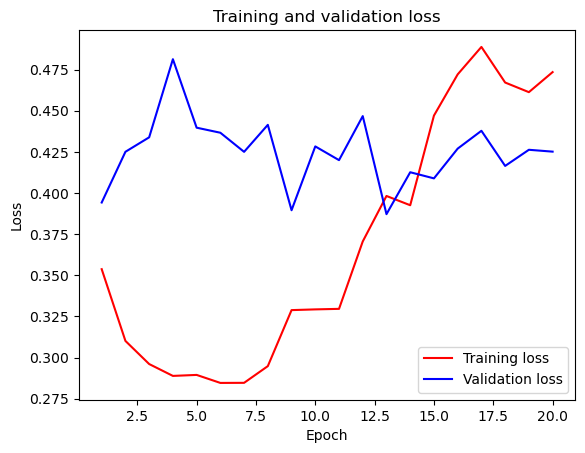

In [ ]:
import matplotlib.pyplot as plt

max_loss_threshold = 2

# Clip the losses to this threshold
clipped_train_losses = np.clip(train_losses, None, max_loss_threshold)
clipped_val_losses = np.clip(val_losses, None, max_loss_threshold)

# Plotting the loss curves
epochs = range(1, len(train_losses) + 1)

plt.figure()

plt.plot(epochs, clipped_train_losses, 'r', label='Training loss')
plt.plot(epochs, clipped_val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Step 10. Go even further!
There are many other things you could try, in order to improve performance on the temperature-forecasting problem:
- Adjust the learning rate used by the RMSprop optimizer.
- Try using LSTM layer then a GRU layer then an LSTM layer again?
- Try using a bigger densely connected regressor on top of the recurrent layers: that is, a bigger Dense layer or even a stack of Dense layers.
- Don’t forget to eventually run the best-performing models (in terms of validation MAE) on the test set! Otherwise, you’ll develop architectures that are overfitting to the validation set.

Deep learning right now is still more like an art than a science. We can provide guidelines that suggest what is likely to work or not work on a given problem, but, ultimately, every problem is unique; you’ll have to evaluate different strategies empirically. There is currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must iterate.

<div class="alert alert-block alert-success">

# Main Lessons

Here’s what you should take away:

* When approaching a new problem, it’s good first to establish common-sense baselines for your metric of choice. You can’t tell whether you’re making real progress if you don't have a baseline to beat.

* Try simple models before expensive ones to justify the additional expense. Sometimes a simple model will turn out to be your best option.

* When temporal ordering matters in data, recurrent networks are a great fit and easily outperform models that first flatten the temporal data.

* To use dropout with recurrent networks, you should use time-constant and recurrent dropout masks. These are built into Keras recurrent layers, so you only have to use the dropout and recurrent_dropout arguments of recurrent layers.

* Stacked RNNs provide more representational power than a single RNN layer. They’re also much more expensive and thus not always worth it. Although they offer clear gains on complex problems (such as machine translation), they may not always be relevant to smaller, simpler problems.

</div>